# Deep Learning Assessment: Customer Churn Prediction

In this notebook, you'll apply deep learning concepts to predict customer churn - a critical business challenge. You'll learn how neural networks can identify patterns in customer behavior data to predict which customers are likely to leave.

## Learning Objectives
1. Understand how to structure data for deep learning
2. Build and train a neural network using PyTorch
3. Evaluate model performance on business metrics
4. Implement improvements to a baseline model

## Assessment Criteria
To pass this assessment, your model must achieve:
- Test accuracy > 85% on the holdout set
- F1 score > 0.80 for the churn class

These metrics ensure your model is both accurate overall and good at identifying customers likely to churn.

## Reflection Questions

Before you start coding, consider these questions:
- What factors do you think contribute most to customer churn?
- How would you quantify the business cost of false negatives vs false positives?
- Why might a high accuracy model still perform poorly in a business context?

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Data Generation and Feature Engineering

Real-world businesses collect numerous data points about their customers. For this assessment, we'll simulate customer data with features that typically influence churn:

- **Tenure**: How long the customer has been with the company
- **Monthly Charges**: How much the customer pays each month
- **Total Charges**: Cumulative amount paid over the customer's lifetime
- **Support Calls**: Number of calls to customer support
- **Usage Score**: How actively the customer uses the service/product

The code below generates synthetic data with relationships between these features and churn probability.

In [3]:
def generate_customer_data(n_samples=1000):
    """
    Generates synthetic customer data with features that influence churn probability.

    Parameters:
        n_samples: Number of customer records to generate

    Returns:
        X: Feature matrix with shape (n_samples, 5)
        y: Target vector (1 = churned, 0 = stayed)
    """
    # Generate features
    tenure = np.random.randint(1, 72, n_samples)  # 1-72 months
    monthly_charges = np.random.uniform(30, 150, n_samples)  # $30-$150
    total_charges = monthly_charges * tenure + np.random.normal(0, 100, n_samples)
    support_calls = np.random.poisson(2, n_samples)  # Average 2 calls
    usage_score = np.random.uniform(0, 100, n_samples)  # 0-100 usage score

    # Combine features
    X = np.column_stack([tenure, monthly_charges, total_charges, support_calls, usage_score])

    # Generate churn labels based on a rule
    churn_score = (
        -0.1 * tenure +  # Longer tenure = less likely to churn
        0.3 * (monthly_charges / 50) +  # Higher charges = more likely to churn
        0.2 * (support_calls / 2) +  # More support calls = more likely to churn
        -0.4 * (usage_score / 50)  # Higher usage = less likely to churn
    )

    churn_score += np.random.normal(0, 0.1, n_samples)
    y = (churn_score > 0).astype(np.int64)

    return X, y

# Generate data and split into train/test sets
X, y = generate_customer_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

# Print dataset information
print("Dataset Information:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Churn rate in training set: {y_train.mean():.2%}")

Dataset Information:
Training set shape: (800, 5)
Test set shape: (200, 5)
Churn rate in training set: 6.50%


## 2. Data Visualization and Pattern Recognition

Before building a model, it's essential to explore the data to understand patterns and relationships. The visualization below shows how features differ between customers who churned and those who stayed.

#### Reflection Questions:
- What patterns do you observe in the visualizations?
- How might these patterns inform business strategies?
- Why is data exploration an important step before modeling?

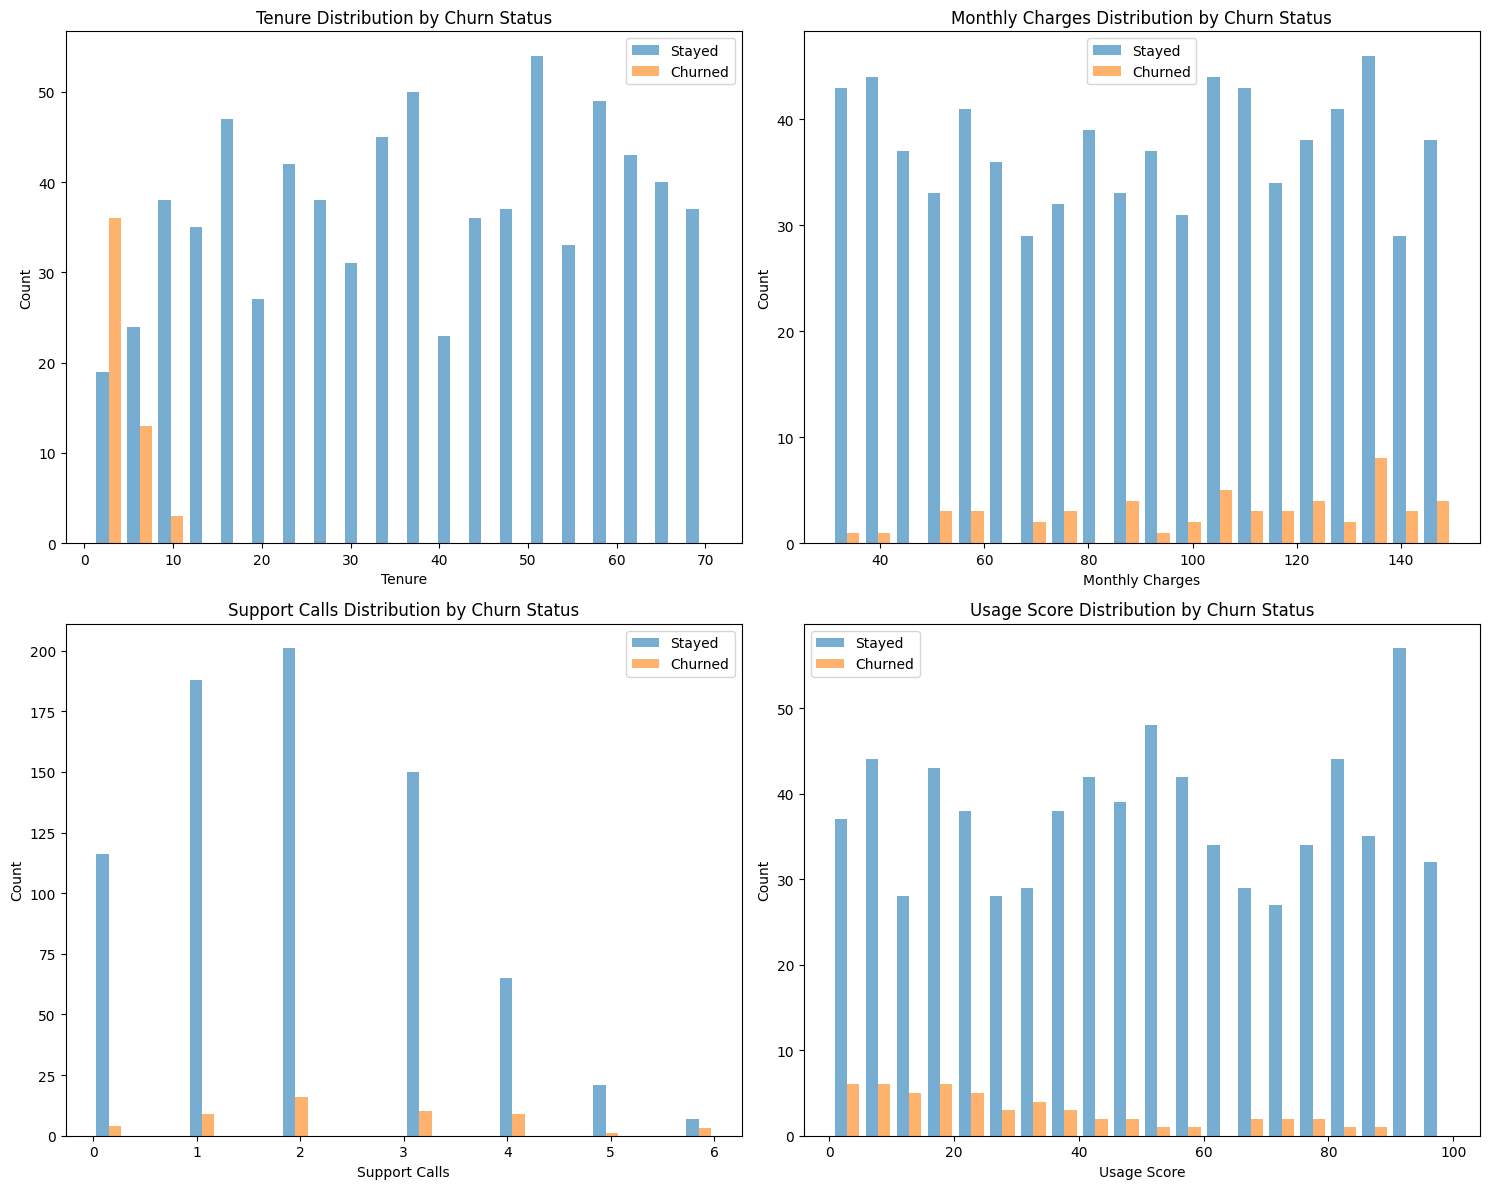

In [4]:
def plot_feature_relationships(X_train, y_train):
    """
    Visualizes the distribution of features for churned vs retained customers.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    feature_names = ['Tenure', 'Monthly Charges', 'Support Calls', 'Usage Score']
    feature_indices = [0, 1, 3, 4]  # Skip total charges as it's derived from tenure

    for i, (name, idx) in enumerate(zip(feature_names, feature_indices)):
        churned = X_train[y_train == 1, idx]
        stayed = X_train[y_train == 0, idx]

        axes[i].hist([stayed, churned], bins=20, label=['Stayed', 'Churned'], alpha=0.6)
        axes[i].set_title(f'{name} Distribution by Churn Status')
        axes[i].set_xlabel(name)
        axes[i].set_ylabel('Count')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Visualize feature relationships
plot_feature_relationships(X_train, y_train)

## 3. Neural Network Architecture

Now we'll build a neural network to predict customer churn. This model will:
1. Take the 5 customer features as input
2. Process them through hidden layers with non-linear activation functions
3. Output a probability of churn

This is a feed-forward neural network with a sigmoid activation in the output layer to produce probabilities between 0 and 1.

#### Reflection Questions:
- Why do we need non-linear activation functions?
- How does the network architecture relate to the complexity of patterns it can learn?
- What would happen if we used a linear model instead?

In [5]:
class ChurnPredictor(nn.Module):
    def __init__(self, input_size=5):
        super(ChurnPredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))  # ReLU helps with vanishing gradient
        x = self.relu(self.layer2(x))  # Multiple layers capture complex patterns
        x = self.sigmoid(self.layer3(x))  # Sigmoid squashes output to [0,1]
        return x

# Initialize the model
model = ChurnPredictor()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("Model architecture:")
print(model)

Model architecture:
ChurnPredictor(
  (layer1): Linear(in_features=5, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


## 4. Model Training

During training, the model learns to minimize the loss function through backpropagation and gradient descent. We'll track both training loss and validation metrics to monitor progress.

#### Reflection Questions:
- Why do we use both training and test sets?
- What patterns in the learning curves might suggest overfitting?
- How does backpropagation work to update the model's weights?

In [6]:
def train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, epochs=100):
    """
    Trains the neural network and tracks performance metrics.

    Returns:
        train_losses: List of loss values during training
        test_metrics: List of tuples containing (epoch, accuracy, f1)
    """
    train_losses = []
    test_metrics = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))
        loss.backward()  # Backpropagation
        optimizer.step()  # Gradient descent
        train_losses.append(loss.item())

        # Evaluation
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_preds = (test_outputs >= 0.5).float()
                accuracy = accuracy_score(y_test, test_preds)
                f1 = f1_score(y_test, test_preds)
                test_metrics.append((epoch, accuracy, f1))
                print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, '
                      f'Test Accuracy: {accuracy:.4f}, F1: {f1:.4f}')

    return train_losses, test_metrics

# Train the model
print("Training baseline model...")
train_losses, test_metrics = train_model(model, X_train_tensor, y_train_tensor,
                                        X_test_tensor, y_test_tensor,
                                        criterion, optimizer)

Training baseline model...
Epoch 10/100, Loss: 0.4959, Test Accuracy: 0.9400, F1: 0.0000
Epoch 20/100, Loss: 0.2697, Test Accuracy: 0.9400, F1: 0.0000
Epoch 30/100, Loss: 0.1896, Test Accuracy: 0.9400, F1: 0.0000
Epoch 40/100, Loss: 0.1489, Test Accuracy: 0.9400, F1: 0.0000
Epoch 50/100, Loss: 0.1302, Test Accuracy: 0.9400, F1: 0.0000
Epoch 60/100, Loss: 0.1172, Test Accuracy: 0.9400, F1: 0.0000
Epoch 70/100, Loss: 0.1075, Test Accuracy: 0.9400, F1: 0.0000
Epoch 80/100, Loss: 0.0979, Test Accuracy: 0.9550, F1: 0.4706
Epoch 90/100, Loss: 0.0884, Test Accuracy: 0.9550, F1: 0.5714
Epoch 100/100, Loss: 0.0785, Test Accuracy: 0.9550, F1: 0.5714


## 5. Visualizing Training Progress

Visualizing the training process helps us understand how the model learns over time. We'll plot both the training loss and test metrics.

#### Reflection Questions:
- What does the convergence of the loss curve tell us?
- How do we know if we've trained for enough epochs?
- Why might accuracy and F1 score evolve differently?

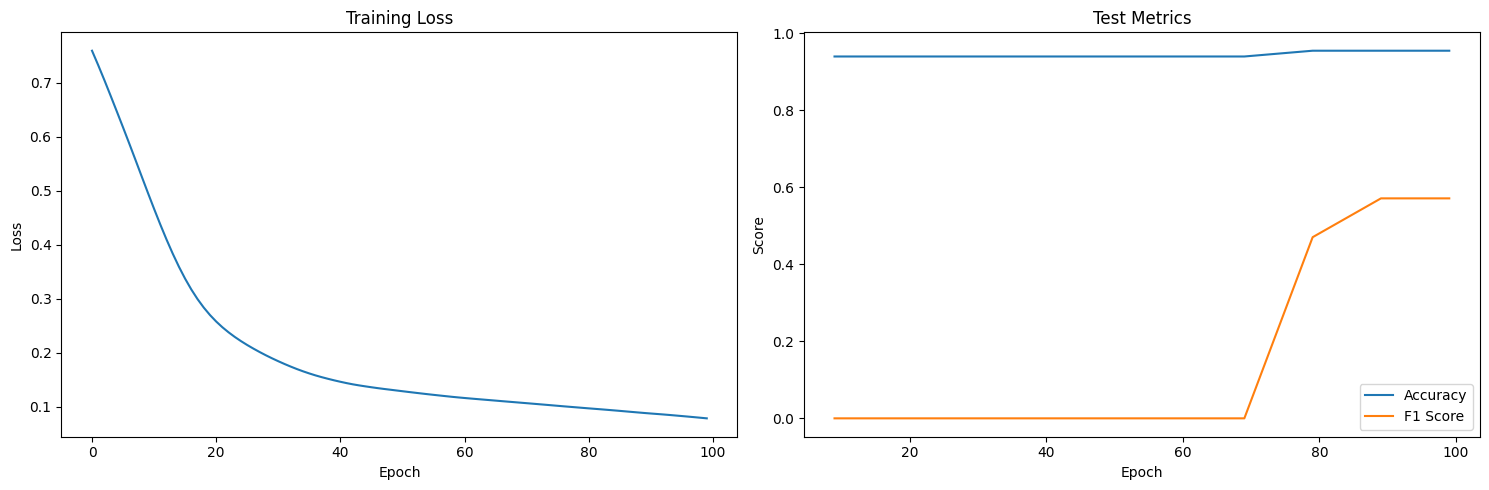

In [7]:
def plot_training_progress(train_losses, test_metrics):
    """
    Visualizes training loss and test metrics over epochs.
    """
    epochs, accuracies, f1_scores = zip(*test_metrics)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training loss
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # Plot test metrics
    ax2.plot(epochs, accuracies, label='Accuracy')
    ax2.plot(epochs, f1_scores, label='F1 Score')
    ax2.set_title('Test Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Visualize training progress
plot_training_progress(train_losses, test_metrics)

## 6. Model Evaluation

Now we'll evaluate the model's performance on the test set using several metrics:
- Accuracy: Overall percentage of correct predictions
- F1 Score: Harmonic mean of precision and recall
- Classification Report: Detailed breakdown of precision, recall, and F1 by class
- Confusion Matrix: Visualization of true vs. predicted labels

#### Reflection Questions:
- Which metric is most important for our business case?
- How do these metrics translate to business value?
- Why might high accuracy be misleading for imbalanced datasets?

In [8]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates model performance and checks if it passes assessment criteria.
    """
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_preds = (test_outputs >= 0.5).float()

        accuracy = accuracy_score(y_test, test_preds)
        f1 = f1_score(y_test, test_preds)

        print("\nFinal Model Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nDetailed Classification Report:")
        print(classification_report(y_test, test_preds))

        # Check if model passes assessment criteria
        passes_accuracy = accuracy > 0.85
        passes_f1 = f1 > 0.80

        print("\nAssessment Results:")
        print(f"Accuracy > 85%: {'✓' if passes_accuracy else '✗'}")
        print(f"F1 Score > 0.80: {'✓' if passes_f1 else '✗'}")
        print(f"Overall: {'PASS' if (passes_accuracy and passes_f1) else 'FAIL'}")

        return passes_accuracy and passes_f1

# Evaluate the baseline model
base_passed = evaluate_model(model, X_test_tensor, y_test_tensor)


Final Model Performance:
Accuracy: 0.9550
F1 Score: 0.5714

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       188
         1.0       0.67      0.50      0.57        12

    accuracy                           0.95       200
   macro avg       0.82      0.74      0.77       200
weighted avg       0.95      0.95      0.95       200


Assessment Results:
Accuracy > 85%: ✓
F1 Score > 0.80: ✗
Overall: FAIL


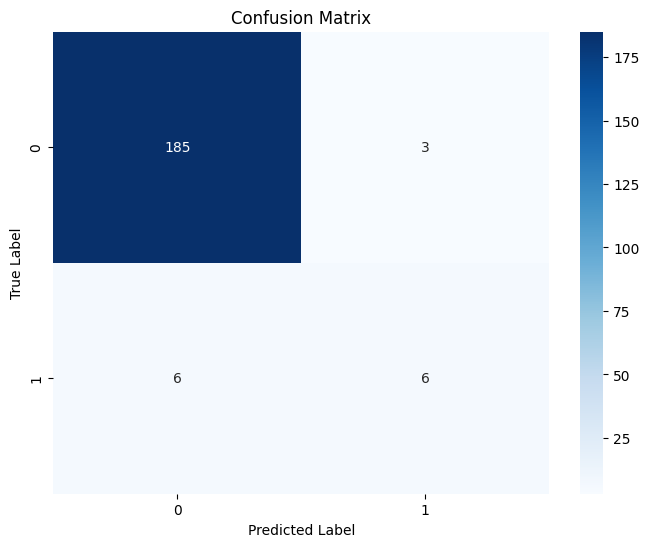


Business Metrics:
Customer Retention Rate: 98.40%
Churn Detection Rate: 50.00%


In [9]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Visualizes confusion matrix and calculates business metrics.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate business metrics
    retention_rate = cm[0,0] / (cm[0,0] + cm[0,1])
    detection_rate = cm[1,1] / (cm[1,0] + cm[1,1])
    print(f"\nBusiness Metrics:")
    print(f"Customer Retention Rate: {retention_rate:.2%}")
    print(f"Churn Detection Rate: {detection_rate:.2%}")

# Plot confusion matrix for baseline model
with torch.no_grad():
    base_preds = (model(X_test_tensor) >= 0.5).float()
plot_confusion_matrix(y_test_tensor, base_preds)

## 7. Your Assessment Task: Improve the Model

If your model didn't pass both criteria (accuracy > 85% and F1 > 0.80), your task is to improve it.

You can:
1. Add more layers or neurons
2. Implement regularization techniques like dropout
3. Add batch normalization
4. Adjust the learning rate
5. Use a different optimizer
6. Train for more epochs

Complete the `ImprovedChurnPredictor` class below with your enhanced architecture, then train and evaluate it.

#### Reflection Questions:
- How does dropout help prevent overfitting?
- Why use different layer sizes in the architecture?
- How do batch normalization and regularization affect model training?

In [ ]:
class ImprovedChurnPredictor(nn.Module):
    def __init__(self, input_size=5):
        super(ImprovedChurnPredictor, self).__init__()
        # TODO: Implement your improved architecture
        # Add layers, dropout, batch normalization, etc.
        pass

    def forward(self, x):
        # TODO: Implement the forward pass
        pass

# TODO: Initialize and train your improved model
# improved_model = ImprovedChurnPredictor()
# criterion = nn.BCELoss()
# optimizer = optim.Adam(improved_model.parameters(), lr=0.005)
# train_losses, test_metrics = train_model(improved_model, X_train_tensor, y_train_tensor,
#                                        X_test_tensor, y_test_tensor,
#                                        criterion, optimizer, epochs=150)

# TODO: Evaluate your improved model
# plot_training_progress(train_losses, test_metrics)
# improved_passed = evaluate_model(improved_model, X_test_tensor, y_test_tensor)

# TODO: Generate and plot confusion matrix
# with torch.no_grad():
#     improved_preds = (improved_model(X_test_tensor) >= 0.5).float()
# plot_confusion_matrix(y_test_tensor, improved_preds)

## 8. Reflection and Business Analysis

After completing the assessment, consider these final reflection questions:

1. What improvements in your model led to better performance?
2. How would you implement this model in a production environment?
3. What additional data would make the model more effective?
4. How would you quantify the ROI of this churn prediction system?
5. What ethical considerations should be addressed when deploying this model?

In your answer, analyze both the technical improvements and their business implications.